# Aggregate radial network and prepare for MATPOWER
In this notebook code for aggregating a radial network and preparing it for power flows is presented.

## Dependencies
This example has several dependencies not included in PowerGraphs. To run this example the dependencies should be installed separately. 

To be able to run power flows pypsa or pandapower should be installed. They have to be installed on the same Python version as the one used by PyCall. To change the python version used by PyCall, please refer to the PyCall documentation

## Load packages
First we need to load the package PowerGraphs for aggregating and saving the grid.

In [1]:
using PowerGraphs
using PyCall
using GraphPlot # For plotting
using Gadfly # For changing plot size
using Plots, GraphRecipes # For nicer plotting

┌ Info: Precompiling PowerGraphs [4cf3ad31-9d4e-4532-9fdd-b80a3a06e24f]
└ @ Base loading.jl:1278


## Load the network
When we have loaded the PowerGraphs package we can read in the network.

In [2]:
fname = "east_side.toml"
filepath = joinpath(@__DIR__, joinpath("cases", fname))
example = RadialPowerGraph(filepath)

I don't know switch status.
All switches will be assumed closed.
I don't know if switch or circuit breaker.
All switchgear will be assumed to be switches.


RadialPowerGraph({1133, 1132} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Case(100.0, 1133×13 DataFrame. Omitted printing of 6 columns
│ Row  │ ID     │ type  │ Pd        │ Qd      │ Gs      │ Bs      │ area_num │
│      │ String │ Int64 │ Float64   │ Float64 │ Float64 │ Float64 │ Int64    │
├──────┼────────┼───────┼───────────┼─────────┼─────────┼─────────┼──────────┤
│ 1    │ 1      │ 1     │ 0.014979  │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 2    │ 2      │ 1     │ 0.0248502 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 3    │ 3      │ 1     │ 0.0540229 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 4    │ 4      │ 1     │ 0.0271138 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 5    │ 5      │ 1     │ 0.0619091 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 6    │ 6      │ 1     │ 0.0097121 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 7    │ 7      │ 1     │ 0.039916  │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 8    │ 8      │ 1     │ 0.0632

## Number of short lines
We now have a very large network. However, many of the lines are very short and several don't have any impedance. In the next code cell one can see how many lines are shorter than 2 centimetres. 

In [3]:
df = example.mpc.reldata
# Divide by 1000 to go from km to m
df.length/1000
df[df.length.<2/100,:][:,[:f_bus, :t_bus, :length]]

,f_bus,t_bus,length
,String,String,Float64
1,1021,502,6.25e-5
2,502,619,0.0123225
3,729,1092,5.85937e-5
4,1092,466,0.00015625
5,941,250,0.000101562
6,981,338,5.46875e-5
7,296,1028,6.25e-5
8,1028,730,6.25e-5
9,250,759,0.000203125


## Merge line segments
Sometimes one line is represented as several line segements. This is the case for this test network. One easy method for making the network smaller is therefore to merge the segements. Before merging the lines we specify, which of the features of the lines should be aggregated. In the code below we specify that we want failure frequencies and line lengths to be aggregated, before we merge the line segments.

In [4]:
aggregators = Dict(:reldata => Dict(:failure_frequency_permanent => 0.0,
									:failure_frequency_temporary => 0.0,
									:length => 0.0))
red_example = merge_line_segments(example, aggregators=aggregators)

RadialPowerGraph({440, 439} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Case(100.0, 440×13 DataFrame. Omitted printing of 6 columns
│ Row │ ID     │ type  │ Pd        │ Qd      │ Gs      │ Bs      │ area_num │
│     │ String │ Int64 │ Float64   │ Float64 │ Float64 │ Float64 │ Int64    │
├─────┼────────┼───────┼───────────┼─────────┼─────────┼─────────┼──────────┤
│ 1   │ 321    │ 3     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 2   │ 601    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 3   │ 341    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 4   │ 598    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 5   │ 765    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 6   │ 400    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 7   │ 52     │ 1     │ 0.0345734 │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 8   │ 473    │ 1     │ 0.0       │ 0.0     

Before merging we had 1133 buses in the case, now we have only 440 buses. We can also check how many lines shorter than 2cm we hace now:

In [5]:
df = red_example.mpc.reldata
# Divide by 1000 to go from km to m
df.length/1000
df[df.length.<2/100,:][:,[:f_bus, :t_bus, :length]]

,f_bus,t_bus,length
,String,String,Float64
1,601,341,0.000171875
2,598,765,1.5625e-5
3,765,400,1.5625e-5
4,400,473,1.5625e-5
5,196,767,9.375e-5
6,196,456,6.25e-5
7,501,1033,0.00328254
8,431,278,1.5625e-5
9,552,931,0.000613281


There is now 202 lines shorter than 2cm. This is a big change compare to before when the number was 940. To be able to run power flows we will also remove lines with a low impedance. 

## Removing low impedance lines
We wil now remove low impedance lines. At the moment this functionality does not keep information about switches, fault indicators or failure rates. It merely takes the everyting connected to one end of the low impedance line and connects it to the other end. Afterwards the line and the empty end are deleted.

In [6]:
small = remove_low_impedance_lines(red_example, 1e-5)

I don't know switch status.
All switches will be assumed closed.
I don't know if switch or circuit breaker.
All switchgear will be assumed to be switches.


PowerGraph({128, 127} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Case(100.0, 128×13 DataFrame. Omitted printing of 6 columns
│ Row │ ID     │ type  │ Pd        │ Qd      │ Gs      │ Bs      │ area_num │
│     │ String │ Int64 │ Float64   │ Float64 │ Float64 │ Float64 │ Int64    │
├─────┼────────┼───────┼───────────┼─────────┼─────────┼─────────┼──────────┤
│ 1   │ 321    │ 3     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 2   │ 601    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 3   │ 196    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 4   │ 501    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 5   │ 1033   │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 6   │ 424    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 7   │ 552    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 8   │ 931    │ 1     │ 0.0       │ 0.0     │ 0.0 

## Plot the network
We will now plot the network, to check that it looks reasonable.

There are two nice options for plotting. We can use GraphPlots as demonstrated below.

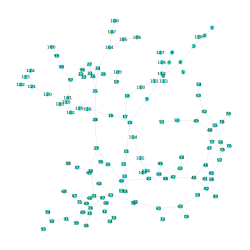

In [7]:
set_default_plot_size(25cm, 25cm)
gplot(small.G, nodelabel=1:n_vertices(small), arrowlengthfrac=0)

Another nice option for plotting is to use Plots and GraphRecipes.

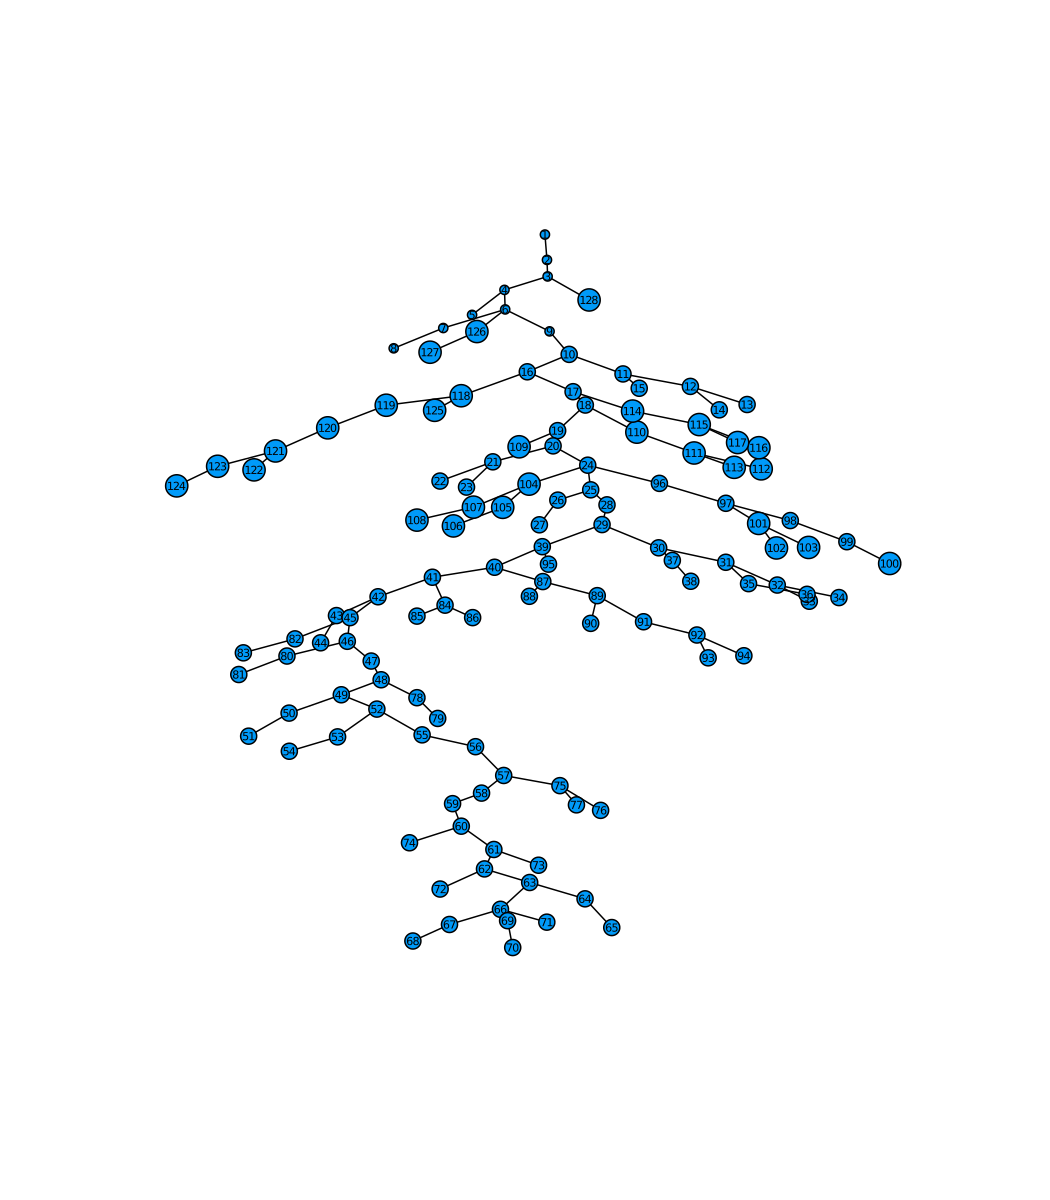

In [8]:
gr(alpha=1, size=(700,800), dpi=150)
# Plotly is a nice backend that allows for interacting with the plot (zoomin, paning, ...). However, it is no
# supported by GitHub
# plotly(alpha=1, size=(700,800), dpi=150)
graphplot(small.G, method=:tree, nodeshape=:circle, names=1:n_vertices(small), curves=false, fontsize=5, self_edge_size=0.5)

## Running power flow
First we have to name the buses correctly

In [9]:
mpc = deepcopy(small.mpc)

Case(100.0, 128×13 DataFrame. Omitted printing of 6 columns
│ Row │ ID     │ type  │ Pd        │ Qd      │ Gs      │ Bs      │ area_num │
│     │ String │ Int64 │ Float64   │ Float64 │ Float64 │ Float64 │ Int64    │
├─────┼────────┼───────┼───────────┼─────────┼─────────┼─────────┼──────────┤
│ 1   │ 321    │ 3     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 2   │ 601    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 3   │ 196    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 4   │ 501    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 5   │ 1033   │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 6   │ 424    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 7   │ 552    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 8   │ 931    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 9   │ 641    │ 1     │ 0.0       │ 0.0     │ 0.0     │ 0.0     │ 0        │
│ 10

We can now run the power flow using pypsa

In [18]:
pp = pyimport("pandapower")
ppc = to_ppc(mpc)
pp.converter.from_ppc(ppc)
pp.runpp(ppc)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



LoadError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\sigurdj\.julia\packages\PyCall\BcTLp\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'KeyError'>
KeyError('load')
  File "C:\Users\sigurdj\AppData\Local\Programs\Python\Python39\lib\site-packages\pandapower\run.py", line 216, in runpp
    _init_runpp_options(net, algorithm=algorithm, calculate_voltage_angles=calculate_voltage_angles,
  File "C:\Users\sigurdj\AppData\Local\Programs\Python\Python39\lib\site-packages\pandapower\auxiliary.py", line 922, in _init_runpp_options
    if not (np.any(net["load"]["const_z_percent"].values)


It should also be possible to run the power flow using pandapower, but we didn't manage to make it work using PyCall. To use pandapower the easiest is to pickle the variabl `ppc` and load it in Python.

## Write network to matpower
We can now write the network to csv files for later processing in MATLAB

In [13]:
to_csv(mpc, joinpath(@__DIR__, "reduced_matpower"))

In [15]:
mpc.bus

,ID,type,Pd,Qd,Gs,Bs,area_num,Vm,Va
,String,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,321,3,0.0,0.0,0.0,0.0,0,1.0,0.0
2,601,1,0.0,0.0,0.0,0.0,0,1.0,0.0
3,196,1,0.0,0.0,0.0,0.0,0,1.0,0.0
4,501,1,0.0,0.0,0.0,0.0,0,1.0,0.0
5,1033,1,0.0,0.0,0.0,0.0,0,1.0,0.0
6,424,1,0.0,0.0,0.0,0.0,0,1.0,0.0
7,552,1,0.0,0.0,0.0,0.0,0,1.0,0.0
8,931,1,0.0,0.0,0.0,0.0,0,1.0,0.0
9,641,1,0.0,0.0,0.0,0.0,0,1.0,0.0
